In [1]:
import numpy as np
from sympy import *
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
init_printing()

### Helpers

Create rotational matrix generator.

In [86]:
def Rotate(p, theta, o, direction):
    """
    Rotate a point about an direction through a point.
    Represents a counterclockwise rotation by theta about the line passing through point pointing in direction.
    :param p: The point to be rotated.
    :param theta: How much to rotate p.
    :param o: The origin of the rotational axis.
    :param direction: The direction of the rotational axis.
    """
    
    # Ensure direction is matrix (for norm).
    direction = Matrix(direction)
    
    # Unpack.
    u, v, w = direction / direction.norm()
    x, y, z = p
    a, b, c = o
    
    x1 = (a*(v**2+w**2)-u*(b*v+c*w-u*x-v*y-w*z))*(1-cos(theta))+x*cos(theta)+(-c*v+b*w-w*y+v*z)*sin(theta)
    y1 = (b*(u**2+w**2)-v*(a*u+c*w-u*x-v*y-w*z))*(1-cos(theta))+y*cos(theta)+(c*u-a*w+w*x-u*z)*sin(theta)
    z1 = (c*(u**2+v**2)-w*(a*u+b*v-u*x-v*y-w*z))*(1-cos(theta))+z*cos(theta)+(-b*u+a*v-v*x+u*y)*sin(theta)
    
    return Matrix((x1, y1, z1))

Create pretty simplification function.

In [87]:
def pretty(eqn, expressions, symbols):
    """
    Does pretty simplification by replacing expressions in a expression or matrix with symbols.
    :param eqn: The desired input expression or matrix.
    :param expressions: The expressions to replace.
    :param symbols: The symbols to use.
    """
    
    eqn = eqn.copy()

    for expr, sub in zip(expressions, symbols):
        eqn = eqn.subs(expr, sub)
        
    return simplify(eqn)

In [88]:
def norm(M):
    return sqrt(M[0]**2 + M[1]**2 + M[2]**2)

### Forward Kinematics

Define lengths for arm segments. Graph points for base condition.

<IPython.core.display.Javascript object>


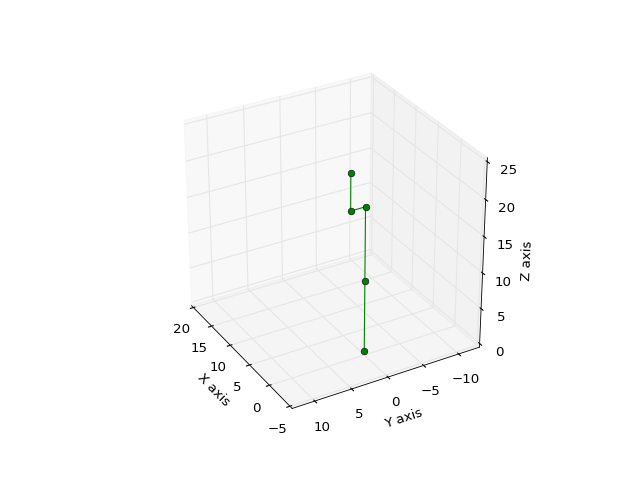

In [89]:
l1 = 10
l2 = 10
l3 = 2
l4 = 5

p0 = (0, 0, 0)
p1 = (0, 0, l1)
p2 = (0, 0, l1 + l2)
p3 = (0, l3, l1 + l2)
p4 = (0, l3, l1 + l2 + l4)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-5, 20)
ax.set_ylim(-12.5, 12.5)
ax.set_zlim(0, 25)
ax.set_aspect('equal')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.view_init(30, 150)

points = [p0, p1, p2, p3, p4]
xs, ys, zs = zip(*points)
ax.plot(xs, ys, zs, 'go-')
plt.show()

Run test cases for rotations about origin.

In [90]:
theta = Symbol('theta')
nx = (1, 0, 0)
ny = (0, 1, 0)
nz = (0, 0, 1)
o = (0, 0, 0)

In [91]:
# Rotate p about x.
p = Matrix((1, 0, 0))
Rotate(p, theta, o, nx)

⎡1⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [92]:
# Rotate p about y.
p = Matrix((1, 0, 0))
Rotate(p, theta, o, ny)

⎡cos(θ) ⎤
⎢       ⎥
⎢   0   ⎥
⎢       ⎥
⎣-sin(θ)⎦

In [93]:
# Rotate p about z.
p = Matrix((1, 0, 0))
Rotate(p, theta, o, nz)

⎡cos(θ)⎤
⎢      ⎥
⎢sin(θ)⎥
⎢      ⎥
⎣  0   ⎦

Define all variables and angles.

In [94]:
theta1, theta2, theta3, theta4 = symbols('theta_1 theta_2 theta_3 theta_4', real=True)
l1, l2, l3, l4 = symbols('l_1 l_2 l_3 l_4', positive=True)

o0 = (0, 0, 0)
o1 = (0, 0, l1)
o3 = (0, l3, l1 + l2)

Solving for $p_0$ is trivial. It is always at the defined origin.

In [95]:
p0 = Matrix((0, 0, 0))
p0

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

To solve for $p_1$, account for $\theta_1$ and $\theta_2$.

In [96]:
p1 = Matrix((0, 0, l1))
p1_sym = symbols('p_1x p_1y p_1z')

p1 = Rotate(p1, theta2, o0, ny)
p1 = Rotate(p1, theta1, o0, nz)

p1 = p1.expand()

simplify(p1)

⎡l₁⋅sin(θ₂)⋅cos(θ₁)⎤
⎢                  ⎥
⎢l₁⋅sin(θ₁)⋅sin(θ₂)⎥
⎢                  ⎥
⎣    l₁⋅cos(θ₂)    ⎦

To solve for $p_2$, account for $\theta_1$ through $\theta_3$ (inclusive).

In [97]:
p2 = Matrix((0, 0, l1 + l2))
p2_sym = symbols('p_2x p_2y p_2z')

p2 = Rotate(p2, theta3, o1, ny)
p2 = Rotate(p2, theta2, o0, ny)
p2 = Rotate(p2, theta1, o0, nz)

p2 = p2.expand()

pretty(p2, p1, p1_sym)

⎡l₂⋅sin(θ₂ + θ₃)⋅cos(θ₁) + p₁ₓ ⎤
⎢                              ⎥
⎢l₂⋅sin(θ₁)⋅sin(θ₂ + θ₃) + p_1y⎥
⎢                              ⎥
⎣    l₂⋅cos(θ₂ + θ₃) + p_1z    ⎦

To solve for $p_3$, account for the same rotations as $p_2$.

In [98]:
p3 = Matrix((0, l3, l1 + l2))
p3_sym = symbols('p_3x p_3y p_3z')

p3 = Rotate(p3, theta3, o1, ny)
p3 = Rotate(p3, theta2, o0, ny)
p3 = Rotate(p3, theta1, o0, nz)

p3 = p3.expand()

pretty(p3, p2, p2_sym)

⎡-l₃⋅sin(θ₁) + p₂ₓ⎤
⎢                 ⎥
⎢l₃⋅cos(θ₁) + p_2y⎥
⎢                 ⎥
⎣      p_2z       ⎦

To solve for $p_4$, account for the all rotations.

In [99]:
p4 = Matrix((0, l3, l1 + l2 + l4))

p4 = Rotate(p4, theta4, o3, ny)
p4 = Rotate(p4, theta3, o1, ny)
p4 = Rotate(p4, theta2, o0, ny)
p4 = Rotate(p4, theta1, o0, nz)

p4 = p4.expand()

pretty(p4, p3, p3_sym)

⎡l₄⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₁) + p₃ₓ ⎤
⎢                                   ⎥
⎢l₄⋅sin(θ₁)⋅sin(θ₂ + θ₃ + θ₄) + p_3y⎥
⎢                                   ⎥
⎣    l₄⋅cos(θ₂ + θ₃ + θ₄) + p_3z    ⎦

Graph some test conditions.

In [100]:
def graph_fk(lengths, angles):
    sub = [(theta1, angles[0]), (theta2, angles[1]), (theta3, angles[2]), (theta4, angles[3]),
           (l1, lengths[0]), (l2, lengths[1]), (l3, lengths[2]), (l4, lengths[3])]

    points = [p0, p1.subs(sub), p2.subs(sub), p3.subs(sub), p4.subs(sub)]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(-5, 20)
    ax.set_ylim(-12.5, 12.5)
    ax.set_zlim(0, 25)
    ax.set_aspect('equal')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.view_init(30, 150)
    
    xs, ys, zs = zip(*points)

    ax.plot(xs, ys, zs, 'go-')
    plt.show()
    
    return points

<IPython.core.display.Javascript object>


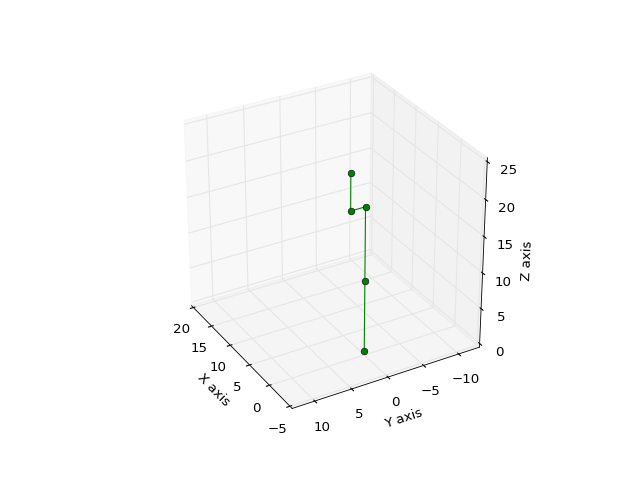

⎡⎡0⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡0 ⎤⎤
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎢0⎥  ⎢0 ⎥  ⎢0 ⎥  ⎢2 ⎥  ⎢2 ⎥⎥
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣0⎦  ⎣10⎦  ⎣20⎦  ⎣20⎦  ⎣25⎦⎦

In [101]:
lengths = (10, 10, 2, 5)
angles = (0, 0, 0, 0)
graph_fk(lengths, angles)

<IPython.core.display.Javascript object>


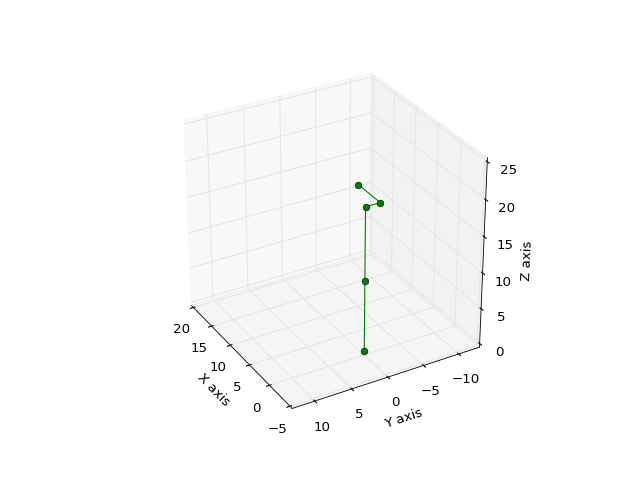

⎡⎡0⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡0 ⎤, ⎡5 ⎤⎤
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎢0⎥  ⎢0 ⎥  ⎢0 ⎥  ⎢-2⎥  ⎢-2⎥⎥
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣0⎦  ⎣10⎦  ⎣20⎦  ⎣20⎦  ⎣20⎦⎦

In [119]:
angles = (0, 0, 0, pi/2)
graph_fk(lengths, angles)

<IPython.core.display.Javascript object>


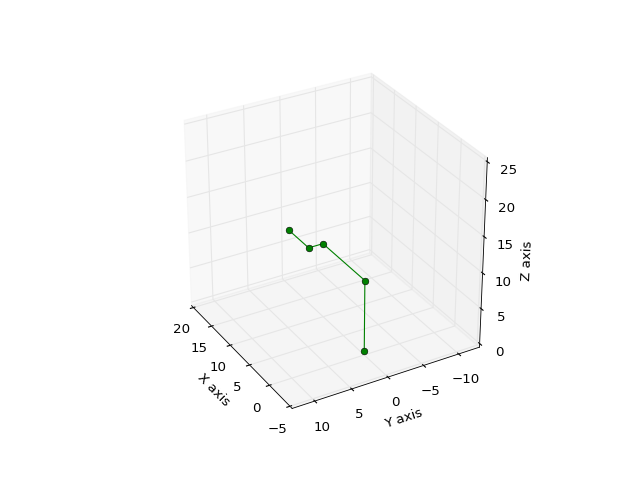

⎡⎡0⎤, ⎡0 ⎤, ⎡10⎤, ⎡10⎤, ⎡15⎤⎤
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎢0⎥  ⎢0 ⎥  ⎢0 ⎥  ⎢2 ⎥  ⎢2 ⎥⎥
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣0⎦  ⎣10⎦  ⎣10⎦  ⎣10⎦  ⎣10⎦⎦

In [19]:
angles = (0, 0, pi/2 , 0)
graph_fk(lengths, angles)

<IPython.core.display.Javascript object>


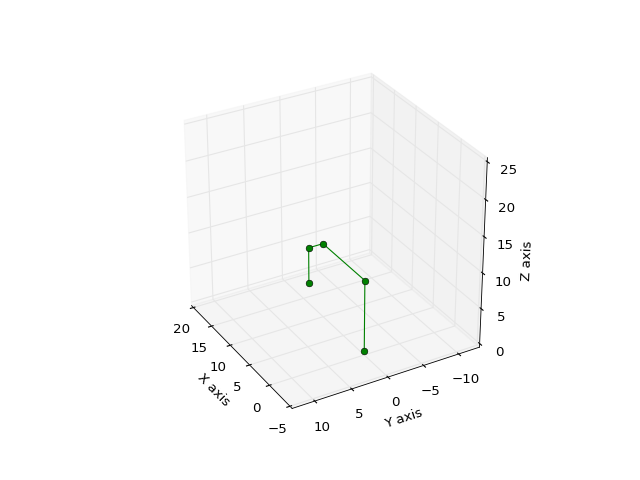

⎡⎡0⎤, ⎡0 ⎤, ⎡10⎤, ⎡10⎤, ⎡10⎤⎤
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎢0⎥  ⎢0 ⎥  ⎢0 ⎥  ⎢2 ⎥  ⎢2 ⎥⎥
⎢⎢ ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣0⎦  ⎣10⎦  ⎣10⎦  ⎣10⎦  ⎣5 ⎦⎦

In [20]:
angles = (0, 0, pi/2, pi/2)
graph_fk(lengths, angles)

<IPython.core.display.Javascript object>


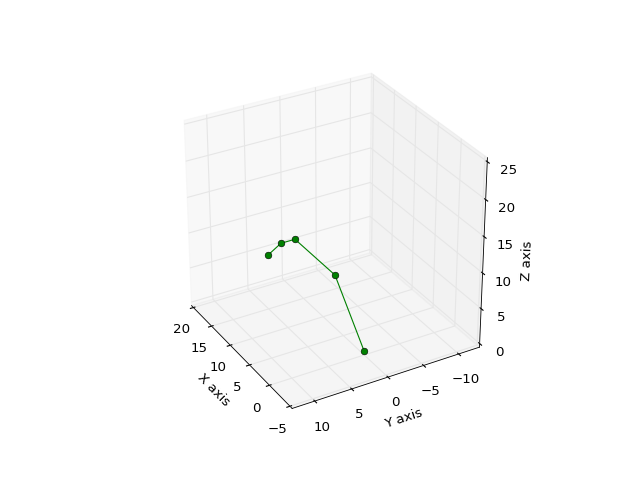

⎡                                       ⎡     15⋅√2⎤⎤
⎢⎡0⎤, ⎡5⋅√2⎤, ⎡5⋅√2 + 10⎤, ⎡5⋅√2 + 10⎤, ⎢10 + ─────⎥⎥
⎢⎢ ⎥  ⎢    ⎥  ⎢         ⎥  ⎢         ⎥  ⎢       2  ⎥⎥
⎢⎢0⎥  ⎢ 0  ⎥  ⎢    0    ⎥  ⎢    2    ⎥  ⎢          ⎥⎥
⎢⎢ ⎥  ⎢    ⎥  ⎢         ⎥  ⎢         ⎥  ⎢    2     ⎥⎥
⎢⎣0⎦  ⎣5⋅√2⎦  ⎣  5⋅√2   ⎦  ⎣  5⋅√2   ⎦  ⎢          ⎥⎥
⎢                                       ⎢   5⋅√2   ⎥⎥
⎢                                       ⎢   ────   ⎥⎥
⎣                                       ⎣    2     ⎦⎦

In [21]:
angles = (0, pi/4, pi/4, pi/4)
graph_fk(lengths, angles)

<IPython.core.display.Javascript object>


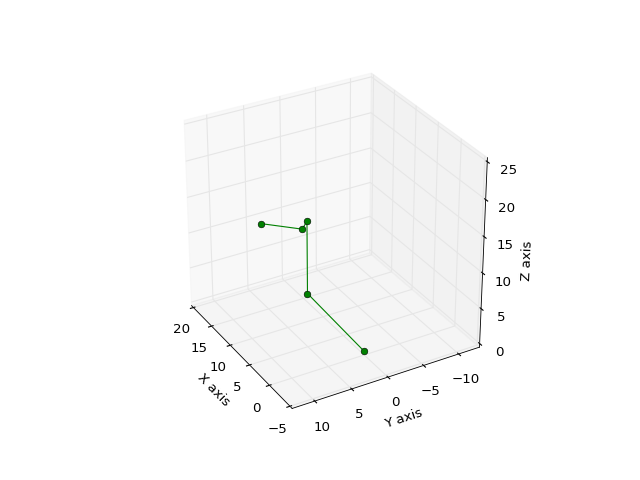

⎡                                       ⎡3⋅√2     ⎤⎤
⎢⎡0⎤, ⎡ 5  ⎤, ⎡    5    ⎤, ⎡ -√2 + 5 ⎤, ⎢──── + 5 ⎥⎥
⎢⎢ ⎥  ⎢    ⎥  ⎢         ⎥  ⎢         ⎥  ⎢ 2       ⎥⎥
⎢⎢0⎥  ⎢ 5  ⎥  ⎢    5    ⎥  ⎢ √2 + 5  ⎥  ⎢         ⎥⎥
⎢⎢ ⎥  ⎢    ⎥  ⎢         ⎥  ⎢         ⎥  ⎢7⋅√2     ⎥⎥
⎢⎣0⎦  ⎣5⋅√2⎦  ⎣5⋅√2 + 10⎦  ⎣5⋅√2 + 10⎦  ⎢──── + 5 ⎥⎥
⎢                                       ⎢ 2       ⎥⎥
⎢                                       ⎢         ⎥⎥
⎣                                       ⎣5⋅√2 + 10⎦⎦

In [22]:
angles = (pi/4, pi/4, -pi/4, pi/2)
points = graph_fk(lengths, angles)
points

### Inverse Kinematics

Given a 4 DOF system, there needs to be additional constraints aside from a point in space to avoid obtaining infinite solutions. For a general hand-like robot, it is helpful to define the direction of the vector created by the last two points. Redefine points $p_0$ to $p_4$ as $A$ to $E$.

The directional constraint, $\phi$, defines the angle formed by the vector $\overrightarrow{DE}$ and the XY-plane. The point $(x, y, z)$ defines the desired target point in space.

In [23]:
x, y, z, phi = symbols('x y z phi', real=True)

Drawing out the diagram basically reveals two similar triangles. Connecting all of the vertices reveals a trapazoid. The two diagonals are known. Two sides are known. Let the sides be $(a,b,c,d)$. $a = l_4\sin{\left(\phi\right)}$ and $d = \sqrt{a^2 + l_3^2}$. The diagonals are $l_3$ and the distance of the target from the origin. $c$ can be solved using the equations detailed [here](http://mathworld.wolfram.com/Trapezoid.html).

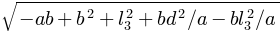

In [24]:
a, b, c, d = symbols('a, b, c, d', real=True)
c1 = solve(l3**2 - (a*b**2-a**2*b-a*c**2+b*d**2)/(b-a), c)[1]
c1

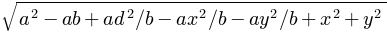

In [25]:
c2 = solve(x**2+y**2 - (a*b**2-a**2*b-a*d**2+b*c**2)/(b-a), c)[1]
c2

Setting both of the above equations equal to each other allows the solution for $b$ to be found. We need to find $\theta_0$, the angle difference caused by $l_3$. We can solve for the opposite leg of the right triangle and use it along with $b$ to find the desired angle. The angle $R$ is defined to be $\theta_1 - \theta_0$.

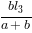

In [26]:
u = Symbol('u', positive=True)
u_soln = solve(a / (l3 - u) - b / u, u)[0]
u_soln

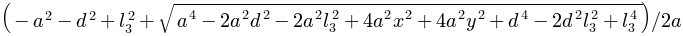

In [27]:
b_soln = solve(c1 - c2, b)[1]
simplify(b_soln.expand())

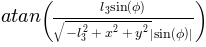

In [28]:
theta_0 = atan(u_soln.subs(b, b_soln) / b_soln).subs([(a, l4*sin(phi)),(d, sqrt(l3**2+(l4*sin(phi))**2))])
simplify(theta_0.expand())

We need to rewrite this equation because $\phi$ can cause this equation to be undefined and it is known analytically that $\phi$ does not play a role here.

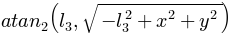

In [29]:
theta_0 = atan2(l3, sqrt(x**2+y**2-l3**2))
theta_0

The next step is to solve for C. We can define the vector $\overrightarrow{V} = \overrightarrow{CE}$. $C$ is really just $\overrightarrow{OC}$. Therefore, $\overrightarrow{C} = \overrightarrow{T} - \overrightarrow{CE}$. The vector $\overrightarrow{CE}$ can be described as two rotations of $\overrightarrow{{CE}_{0}}$ -- one rotation about the Z-axis and another rotation about a rotated Y-axis vector. $\overrightarrow{D}$ can be solved in a similar manner. Let $\overrightarrow{n}$ be the the Y-axis normal vector rotated by $R$.

In [30]:
theta0 = Symbol('theta_0', real=True)

# Define CD vector.
CD = Matrix((0, 0, l4))

# Define D.
D = Matrix((x, y, z)) - CD
D_sym = symbols('D_x D_y D_z')

# Define oE.
oE = (x, y, z)

# Rotate ny about Z-axis.
R1 = atan2(y, x) - theta0
R2 = atan2(y, x) + theta0

n1 = Rotate(ny, R1, o, nz)
n2 = Rotate(ny, R2, o, nz)
n = [n1, n2]

# Rotate D about rotated Y-normal.
D1 = Rotate(D, phi, oE, n1)
D2 = Rotate(D, phi, oE, n2)

D1 = simplify(D1.expand())
D2 = simplify(D2.expand())

D = [D1, D2]

# Output.
D

⎡⎡-l₄⋅sin(φ)⋅cos(θ₀ - atan2(y, x)) + x⎤, ⎡-l₄⋅sin(φ)⋅cos(θ₀ + atan2(y, x)) + x
⎢⎢                                    ⎥  ⎢                                    
⎢⎢l₄⋅sin(φ)⋅sin(θ₀ - atan2(y, x)) + y ⎥  ⎢-l₄⋅sin(φ)⋅sin(θ₀ + atan2(y, x)) + y
⎢⎢                                    ⎥  ⎢                                    
⎣⎣           -l₄⋅cos(φ) + z           ⎦  ⎣           -l₄⋅cos(φ) + z           

⎤⎤
⎥⎥
⎥⎥
⎥⎥
⎦⎦

In [31]:
n

⎡⎡sin(θ₀ - atan2(y, x))⎤, ⎡-sin(θ₀ + atan2(y, x))⎤⎤
⎢⎢                     ⎥  ⎢                      ⎥⎥
⎢⎢cos(θ₀ - atan2(y, x))⎥  ⎢cos(θ₀ + atan2(y, x)) ⎥⎥
⎢⎢                     ⎥  ⎢                      ⎥⎥
⎣⎣          0          ⎦  ⎣          0           ⎦⎦

In [32]:
# Define CE vector.
CE1 = Matrix((0, l3, l4))
CE2 = Matrix((0, -l3, l4))

# Define C.
C1 = Matrix((x, y, z)) - CE1
C2 = Matrix((x, y, z)) - CE2

C_sym = symbols('C_x C_y C_z')

# Rotate C about Z-axis.
C1 = Rotate(C1, R1, oE, nz)
C2 = Rotate(C2, R2, oE, nz)

# Rotate C about rotated Y-normal.
C1 = Rotate(C1, phi, oE, n1)
C2 = Rotate(C2, phi, oE, n2)

C1 = simplify(C1.expand())
C2 = simplify(C2.expand())

C = [C1, C2]

# Output.
[pretty(C[0], D[0], D_sym), pretty(C[1], D[1], D_sym)]

⎡⎡Dₓ - l₃⋅sin(θ₀ - atan2(y, x)) ⎤, ⎡Dₓ - l₃⋅sin(θ₀ + atan2(y, x)) ⎤⎤
⎢⎢                              ⎥  ⎢                              ⎥⎥
⎢⎢D_y - l₃⋅cos(θ₀ - atan2(y, x))⎥  ⎢D_y + l₃⋅cos(θ₀ + atan2(y, x))⎥⎥
⎢⎢                              ⎥  ⎢                              ⎥⎥
⎣⎣             D_z              ⎦  ⎣             D_z              ⎦⎦

Given $C$, it is possible to use the law of cosines to solve for $\theta_3$. $\theta_3$ can either be positive or negative.

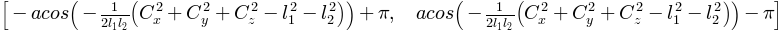

In [34]:
theta_3 = pi - acos((l1**2 + l2**2 - norm(C[1])**2) / (2 * l1 * l2))

sol1 = pretty(theta_3, C[1], C_sym)
sol2 = -sol1
theta_3 = [sol1, sol2]
theta_3

We can solve for $\theta_2$ by assuming that $B$ still rests on the Z-axis. Define $C^{\prime\prime}$ as the point $C$ with only $\theta_3$. Define $C^{\prime}$ as the point $C$ with only $\theta_2$ and $\theta_3$. There are two constraints for the system. $C^{\prime}_z$ must be equal to $C_z$ and $C^{\prime}_x$ must be equal to $\sqrt{C_x^2 + C_y^2}$ to form a radius for $\theta_1$ to complete. Solving either equation will produce the desired results.

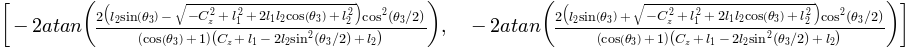

In [113]:
C_pp = (l2 * sin(theta3), 0, l1 + l2 * cos(theta3))
C_p = Rotate(C_pp, theta2, o, ny)
theta_2 = solve(C_p[2] - C_sym[2], theta2)
theta_2

$\theta_1$ can actually be by solved using the forward kinematic equations for $C$.

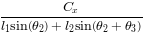

In [36]:
cos_theta_1 = solve(p2[0] - C_sym[0], cos(theta1))[0]
cos_theta_1

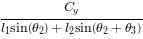

In [37]:
sin_theta_1 = solve(p2[1] - C_sym[1], sin(theta1))[0]
sin_theta_1

In [38]:
theta_1 = solve(tan(theta1) - sin_theta_1 / cos_theta_1, theta1)[0]
theta_1

Solve for the tangent of $\theta_2$ to obtain the desired outcome. Account for multiple solutions.

In [39]:
theta_1 = atan2(C_sym[1], C_sym[0])
theta_1 = [theta_1, theta_1 + pi]
theta_1

Finally, we can solve for $\theta_4$. Define two vectors, $\overrightarrow{DE}$ and $\overrightarrow{BC}$. The dot product can be used to determine the angle. The sign can be determined using the cross product. Define $s$ as the sign. Account for multiple solutions.

$$s = \operatorname{sgn}{\left[ \overrightarrow{n} \cdot \left( \overrightarrow{BC} \times \overrightarrow{DE} \right) \right] }$$

$$
\newcommand{\norm}[1]{\lvert #1 \rvert}
\left[ 
s \cdot \operatorname{acos}{\left( \frac{\overrightarrow{BC} \cdot \overrightarrow{DE} }{\norm{\overrightarrow{BC}} \norm{\overrightarrow{DE}}} \right)}, \quad
2 \pi - s \cdot \operatorname{acos}{\left( \frac{\overrightarrow{BC} \cdot \overrightarrow{DE} }{\norm{\overrightarrow{BC}} \norm{\overrightarrow{DE}}} \right)}
\right]
$$

For most constraint conditions of $(x, y, z, \phi)$, there are at most four solutions (and usually four solutions).

### Testing

In [128]:
def ik(lengths, target, p):
    sys = 0
    
    sub1 = list(zip((l1, l2, l3, l4), lengths))
    sub2 = list(zip((x, y, z), target))
    sub3 = [(phi, p)]
    
    sub = sub1 + sub2 + sub3
    
    theta0_ = N(theta_0.subs(sub))
    sub.append((theta0, theta0_))
    
    D_ = N(D[sys].subs(sub))
    C_ = N(C[sys].subs(sub))
    
    sub4 = list(zip(C_sym, C_))
    sub += sub4
    
    theta3_ = N(theta_3[0].subs(sub))
    sub.append((theta3, theta3_))
    
    theta2_ = N(theta_2[sys].subs(sub))
    sub.append((theta2, theta2_))
    
    theta1_ = N(theta_1[sys].subs(sub))
    sub.append((theta1, theta1_))
    
    n_ = N(n[sys].subs(sub))
    
    B_ = N(p1.subs(sub))
    target = Matrix(target)
    
    BC = N(C_ - B_)
    DE = N(target - D_)
    
    s = sign(n_.dot(BC.cross(DE)))
    
    theta4_ = N(s*acos(BC.dot(DE) / (norm(BC) * norm(DE))))
    # theta4_ = N(2*pi - s*acos(BC.dot(DE) / (norm(BC) * norm(DE))))

    return theta1_, theta2_, theta3_, theta4_

In [129]:
def test_system(lengths, target, p):
    angles = ik(lengths, target, p)
    print(angles)
    points = graph_fk(lengths, angles)
    
    if all(round(N(points[-1][i]), 5) == round(N(target[i]), 5) for i in range(3)):
        print('Test passed!')
    else:
        print('Test failed!')
        
    return points


(0.394791119699762, 0.337675247345273, 2.07145103919948, 0.732466367045035)


<IPython.core.display.Javascript object>


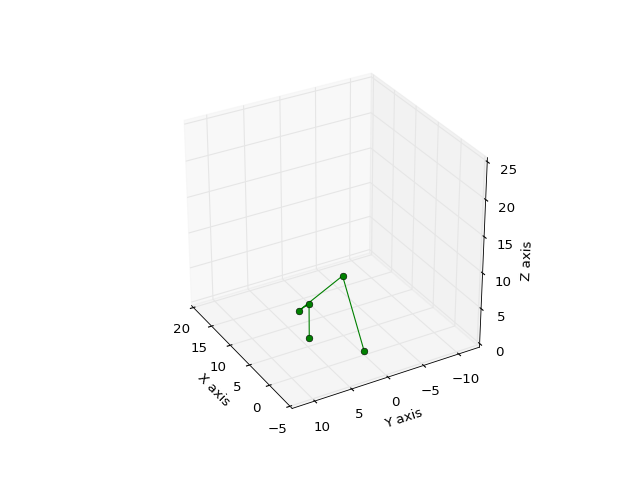

Test passed!


⎡⎡0⎤, ⎡3.05810327577789⎤, ⎡9.23076923076923⎤, ⎡10.0⎤, ⎡10.0⎤⎤
⎢⎢ ⎥  ⎢                ⎥  ⎢                ⎥  ⎢    ⎥  ⎢    ⎥⎥
⎢⎢0⎥  ⎢1.27420969824079⎥  ⎢3.84615384615385⎥  ⎢2.0 ⎥  ⎢2.0 ⎥⎥
⎢⎢ ⎥  ⎢                ⎥  ⎢                ⎥  ⎢    ⎥  ⎢    ⎥⎥
⎣⎣0⎦  ⎣9.43527392286973⎦  ⎣      2.0       ⎦  ⎣2.0 ⎦  ⎣-3.0⎦⎦

In [134]:
lengths = (10, 10, -2, 5)
target = (10, 2, -3)

test_system(lengths, target, pi)